# Optimizing a mesh using a Differentiable Renderer

Differentiable rendering can be used to optimize the underlying 3D properties, like geometry and lighting, by backpropagating gradients from the loss in the image space. In this tutorial, we optimize geometry and texture of a single object based on a dataset of rendered ground truth views. This tutorial demonstrates functionality in `kaolin.render.mesh`, including the key `dibr_rasterization` function.  See detailed [API documentation](https://kaolin.readthedocs.io/en/latest/modules/kaolin.render.mesh.html). Note that this script is didactic and is not meant as a production end-to-end example; for more examples using DIB-R differentiable renderer, see [this repository](https://github.com/nv-tlabs/DIB-R-Single-Image-3D-Reconstruction).

In addition, we demonstrate the use of [Kaolin's 3D checkpoints and training visualization](https://kaolin.readthedocs.io/en/latest/modules/kaolin.visualize.html) with the [Omniverse Kaolin App](https://docs.omniverse.nvidia.com/app_kaolin/app_kaolin/user_manual.html).

Before starting the tutorial please make sure that to have [examples/samples/rendered_clock.zip](examples/samples/rendered_clock.zip) uncompressed.

In [10]:
# !pip install -q matplotlib

import json
import os
import glob
import time

from PIL import Image
import torch
import numpy as np
from matplotlib import pyplot as plt

import kaolin as kal

# path to the rendered image (using the data synthesizer)
rendered_path = "data/Measuring_Cup_Dataset/"
# path to the output logs (readable with the training visualizer in the omniverse app)
logs_path = 'logs/'

# We initialize the timelapse that will store USD for the visualization apps
timelapse = kal.visualize.Timelapse(logs_path) 

In [11]:
# Hyperparameters
num_epoch = 50
batch_size = 2
laplacian_weight = 0.03
image_weight = 0.1
mask_weight = 1.
texture_lr = 5e-2
vertice_lr = 5e-4
scheduler_step_size = 20
scheduler_gamma = 0.5

texture_res = 400

# select camera angle for best visualization
test_batch_ids = [2, 5, 10]
test_batch_size = len(test_batch_ids)

# Generating Training Data

To optimize a mesh, typical training data includes RGB images and segmentation mask. One way to generate this data is to use the Data Generator in the [Omniverse Kaolin App](https://docs.omniverse.nvidia.com/app_kaolin/app_kaolin/user_manual.html#data-generator). We provide sample output of the app in `examples/samples/`.

## Parse synthetic data
We first need to parse the synthetic data generated by the omniverse app.
The omniverse app generate 1 file per type of data (which can be depth map, rgb image, segmentation map), and an additional metadata json file.

The json file contains two main fields:
- camera_properties: Contains all the data related to camera setting such as "clipping_range", "horizontal_aperture", "focal_length", "tf_mat"
- asset_transforms: Those are transformations that are applied by the [Omniverse Kaolin App](https://docs.omniverse.nvidia.com/app_kaolin/app_kaolin/user_manual.html#data-generator), such as rotation / translation between objects or normalization.

In [12]:
num_views = len(glob.glob(os.path.join(rendered_path,'*_rgb.png')))
train_data = []
for i in range(num_views):
    data = kal.io.render.import_synthetic_view(
        rendered_path, i, rgb=True, semantic=True)
    train_data.append(data)

dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                         shuffle=True, pin_memory=True) 

# Loading the Sphere Template

The optimization starts from deforming an input template mesh according to the input image. We will use a sphere template that provides better performance on objects without topological holes. We use "/kaolin/examples/samples/sphere.obj" for convenience.

In [13]:
mesh = kal.io.obj.import_mesh('../samples/sphere.obj', with_materials=True)
mesh = mesh.to_batched().cuda()
mesh.vertices = mesh.vertices * 0.75  # adjust initial size
mesh.vertices.requires_grad = True

texture_map = torch.ones(
    (1, 3, texture_res, texture_res), dtype=torch.float,
    device='cuda', requires_grad=True)

# The topology of the mesh and the uvs are constant
# so we can initialize them on the first iteration only
timelapse.add_mesh_batch(
    iteration=0,
    category='optimized_mesh',
    faces_list=[mesh.faces.cpu()],
    uvs_list=[mesh.uvs[0, ...].cpu()],
    face_uvs_idx_list=[mesh.face_uvs_idx[0, ...].cpu()],
)

# Preparing the losses and regularizer

During training we will use different losses:
- an image loss: an L1 loss based on RGB image.
- a mask loss: an Intersection over Union (IoU) of the segmentation mask with the soft_mask output by DIB-R rasterizer.
- a laplacian loss: to avoid deformation that are too strong.
- a flat loss: to keep a smooth surface and avoid faces intersecting.

For that we need to compute the laplacian matrix and some adjacency information
(the face idx of faces connected to each edge)


In [14]:
## Separate vertices center as a learnable parameter
vertices_init = mesh.vertices.clone().detach()
vertices_init.requires_grad = False

# This is the center of the optimized mesh, separating it as a learnable parameter helps the optimization. 
vertice_shift = torch.zeros((3,), dtype=torch.float, device='cuda',
                            requires_grad=True)

nb_faces = mesh.faces.shape[0]
nb_vertices = vertices_init.shape[1]

## Set up auxiliary laplacian matrix for the laplacian loss
vertices_laplacian_matrix = kal.ops.mesh.uniform_laplacian(
    nb_vertices, mesh.faces) 

# Setting up optimizer

In [15]:
vertices_optim  = torch.optim.Adam(params=[mesh.vertices, vertice_shift],
                                   lr=vertice_lr)
texture_optim = torch.optim.Adam(params=[texture_map], lr=texture_lr)
vertices_scheduler = torch.optim.lr_scheduler.StepLR(
    vertices_optim,
    step_size=scheduler_step_size,
    gamma=scheduler_gamma)
texture_scheduler = torch.optim.lr_scheduler.StepLR(
    texture_optim,
    step_size=scheduler_step_size,
    gamma=scheduler_gamma)

# Set up Differentiable Rendering

In [16]:
def render(in_batch_size, cam_proj, cam_transform, img_shape):
    ### Prepare mesh data with projection regarding to camera ###
    vertices_batch = kal.ops.pointcloud.center_points(mesh.vertices) + vertice_shift

    face_vertices_camera, face_vertices_image, face_normals = \
        kal.render.mesh.prepare_vertices(
            vertices_batch.repeat(in_batch_size, 1, 1),
            mesh.faces, cam_proj, camera_transform=cam_transform)

    ### Perform Rasterization ###
    # Construct attributes that DIB-R rasterizer will interpolate.
    # the first is the UVS associated to each face
    # the second will make a hard segmentation mask
    face_attributes = [
        mesh.face_uvs.repeat(in_batch_size, 1, 1, 1),
        torch.ones((in_batch_size, nb_faces, 3, 1), device='cuda')
    ]

    # If you have nvdiffrast installed you can change rast_backend to
    # nvdiffrast or nvdiffrast_fwd
    image_features, soft_mask, face_idx = kal.render.mesh.dibr_rasterization(
        img_shape[0], img_shape[1], face_vertices_camera[:, :, :, -1],
        face_vertices_image, face_attributes, face_normals[:, :, -1],
        rast_backend='cuda')

    # image_features is a tuple in composed of the interpolated attributes of face_attributes
    texture_coords, mask = image_features
    image = kal.render.mesh.texture_mapping(texture_coords,
                                            texture_map.repeat(in_batch_size, 1, 1, 1), 
                                            mode='bilinear')
    image = torch.clamp(image * mask, 0., 1.)
    return image, soft_mask

# Training

This toy tutorial optimizes geometry and texture of the mesh directly to demonstrate losses, rasterization and 3D checkpoints available in Kaolin.

These components can be combined with a neural architecture of your choice to learn tasks like image to 3D mesh.

In [17]:
for epoch in range(num_epoch):
    for idx, data in enumerate(dataloader):
        vertices_optim.zero_grad()
        texture_optim.zero_grad()
        gt_image = data['rgb'].cuda()
        gt_mask = data['semantic'].cuda()
        cam_transform = data['metadata']['cam_transform'].cuda()
        cam_proj = data['metadata']['cam_proj'].cuda()
        
        ### Render
        image, soft_mask = render(batch_size, cam_proj, cam_transform, gt_image.shape[1:])
        
        ### Compute Losses ###
        image_loss = torch.mean(torch.abs(image - gt_image))
        mask_loss = kal.metrics.render.mask_iou(soft_mask,
                                                gt_mask.squeeze(-1))
        # laplacian loss
        vertices_mov = mesh.vertices - vertices_init
        vertices_mov_laplacian = torch.matmul(vertices_laplacian_matrix, vertices_mov)
        laplacian_loss = torch.mean(vertices_mov_laplacian ** 2) * nb_vertices * 3

        loss = (
            image_loss * image_weight +
            mask_loss * mask_weight +
            laplacian_loss * laplacian_weight
        )
        ### Update the mesh ###
        loss.backward()
        vertices_optim.step()
        texture_optim.step()

    vertices_scheduler.step()
    texture_scheduler.step()
    print(f"Epoch {epoch} - loss: {float(loss)}")
    
    ### Write 3D Checkpoints ###
    pbr_material = [
        {'rgb': kal.io.materials.PBRMaterial(diffuse_texture=torch.clamp(texture_map[0], 0., 1.))}
    ]

    vertices_batch = kal.ops.pointcloud.center_points(mesh.vertices) + vertice_shift

    # We are now adding a new state of the mesh to the timelapse
    # we only modify the texture and the vertices position
    timelapse.add_mesh_batch(
        iteration=epoch,
        category='optimized_mesh',
        vertices_list=[vertices_batch[0]],
        materials_list=pbr_material
    ) 

Epoch 0 - loss: 0.05331701412796974
Epoch 1 - loss: 0.05070902779698372
Epoch 2 - loss: 0.039427824318408966
Epoch 3 - loss: 0.031279537826776505
Epoch 4 - loss: 0.032794881612062454
Epoch 5 - loss: 0.035691358149051666
Epoch 6 - loss: 0.03110179677605629
Epoch 7 - loss: 0.03254855424165726
Epoch 8 - loss: 0.03090905025601387
Epoch 9 - loss: 0.027096271514892578
Epoch 10 - loss: 0.025539414957165718
Epoch 11 - loss: 0.033367402851581573
Epoch 12 - loss: 0.026478175073862076
Epoch 13 - loss: 0.03137635812163353
Epoch 14 - loss: 0.026700153946876526
Epoch 15 - loss: 0.03265947476029396
Epoch 16 - loss: 0.024242032319307327
Epoch 17 - loss: 0.035438407212495804
Epoch 18 - loss: 0.023222418501973152
Epoch 19 - loss: 0.03279987350106239
Epoch 20 - loss: 0.02500869520008564
Epoch 21 - loss: 0.02524416148662567
Epoch 22 - loss: 0.02826644480228424
Epoch 23 - loss: 0.02837497554719448
Epoch 24 - loss: 0.02542220801115036
Epoch 25 - loss: 0.02832704596221447
Epoch 26 - loss: 0.03100368566811084

# Visualize training

You can now use [the Omniverse app](https://docs.omniverse.nvidia.com/app_kaolin/app_kaolin) to visualize the mesh optimization over training by using the training visualizer on "./logs/", where we stored the checkpoints.

You can also show the rendered image generated by DIB-R and the learned texture map with your 2d images libraries.

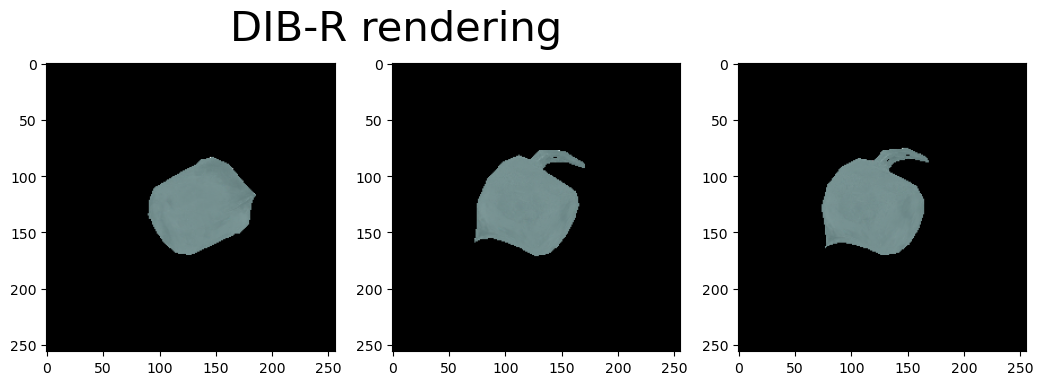

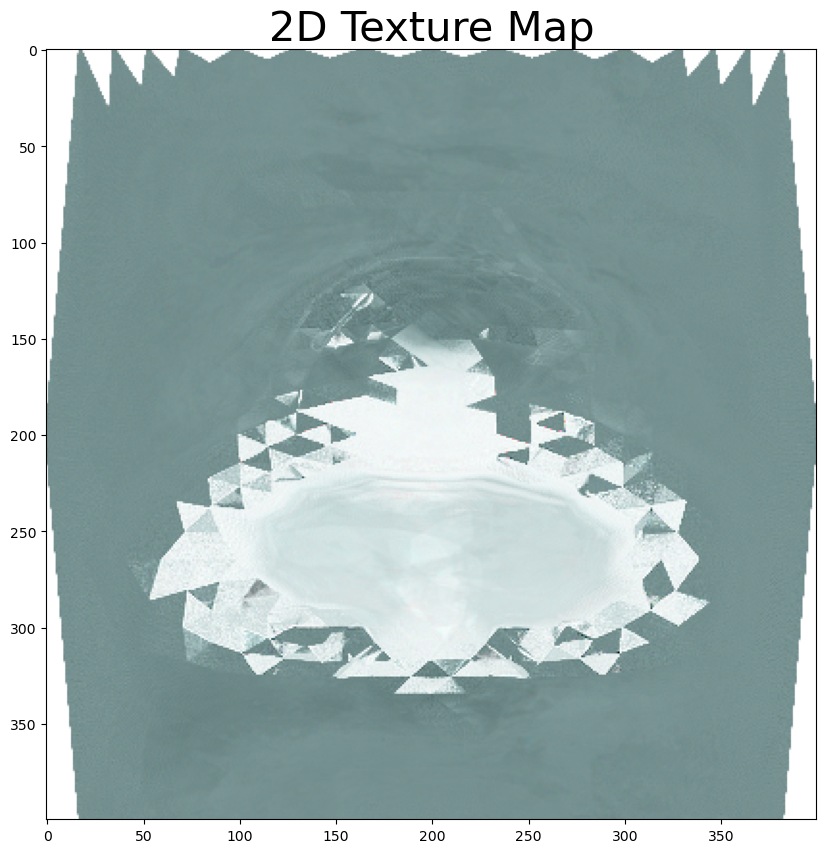

In [18]:
with torch.no_grad():
    # This is similar to a training iteration (without the loss part)
    data_batch = [train_data[idx] for idx in test_batch_ids]
    cam_transform = torch.stack([data['metadata']['cam_transform'] for data in data_batch], dim=0).cuda()
    cam_proj = torch.stack([data['metadata']['cam_proj'] for data in data_batch], dim=0).cuda()

    image, soft_mask = render(test_batch_size, cam_proj, cam_transform, [256, 256])
    
    ## Display the rendered images
    f, axarr = plt.subplots(1, test_batch_size, figsize=(7, 22))
    f.subplots_adjust(top=0.99, bottom=0.79, left=0., right=1.4)
    f.suptitle('DIB-R rendering', fontsize=30)
    for i in range(test_batch_size):
        axarr[i].imshow(image[i].cpu().detach())
        
## Display the texture
plt.figure(figsize=(10, 10))
plt.title('2D Texture Map', fontsize=30)
plt.imshow(torch.clamp(texture_map[0], 0., 1.).cpu().detach().permute(1, 2, 0))